In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras.applications import vgg16
from keras.models import Model, load_model
import keras
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from numpy.random import seed
import tensorflow as tf
import time
from keras import backend as K
import h5py

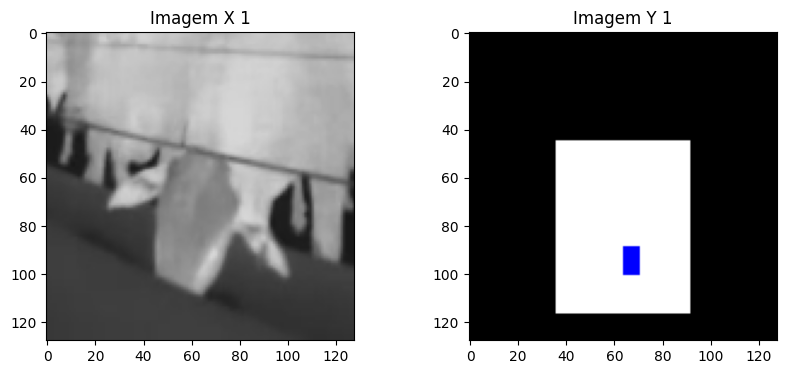

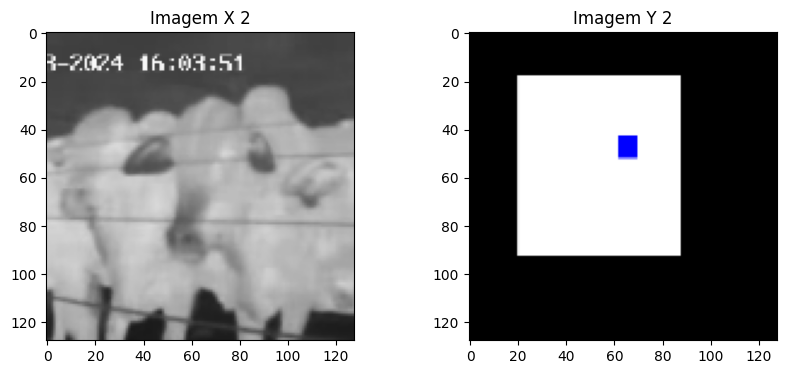

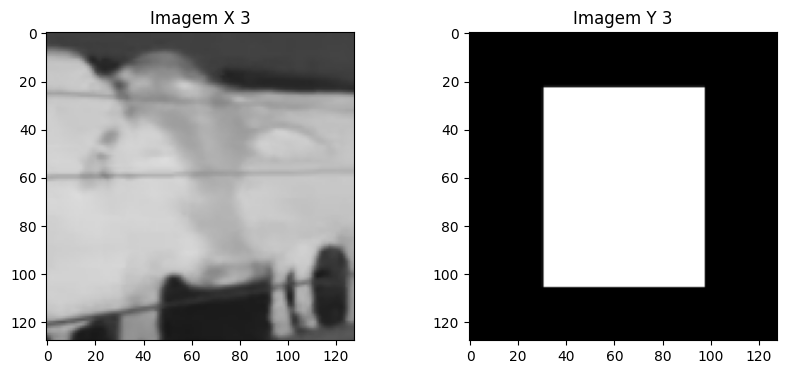

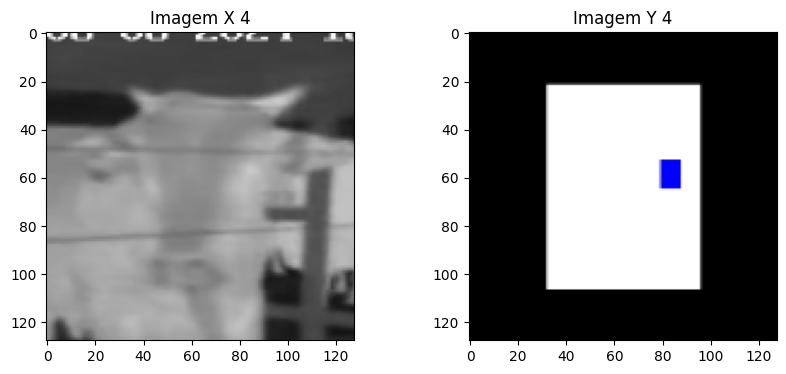

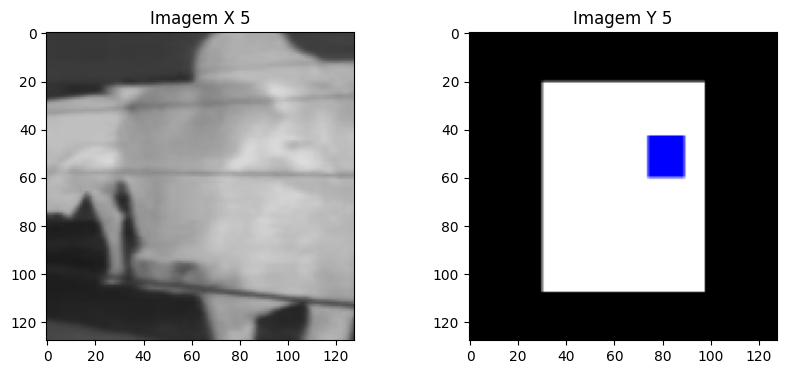

In [3]:
# Abrindo o arquivo .h5
with h5py.File('/content/drive/MyDrive/data/combined_data.h5', 'r') as h5f:
    X_data = h5f['X'][:]
    Y_data = h5f['Y'][:]

# Exibindo algumas imagens
for i in range(5):  # Mostrando as primeiras 5 imagens
    plt.figure(figsize=(10, 4))
    # Plotando a imagem X
    plt.subplot(1, 2, 1)
    plt.imshow(X_data[i])
    plt.title(f'Imagem X {i+1}')
    # Plotando a imagem Y
    plt.subplot(1, 2, 2)
    plt.imshow(Y_data[i])
    plt.title(f'Imagem Y {i+1}')
    plt.show()

In [4]:
X_data = X_data / 255.0
Y_data = Y_data / 255.0

# Definindo tamanho das imagens e outras configurações
img_size = (128, 128)
num_classes = 1  # Segmentação binária (olho ou não olho)
batch_size = 32

# Função para criar o modelo U-Net
Y_data_gray = np.mean(Y_data, axis=-1, keepdims=True)  # Convertendo para escala de cinza

# Certificando que os valores de Y_data estejam entre 0 e 1
Y_data_gray = (Y_data_gray > 0.5).astype(np.uint8)  # Binarizando a máscara (0 ou 1)

# Dividindo os dados em treino e validação
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data_gray, test_size=0.2, random_state=42)

# Função para criar o modelo U-Net (mantida a mesma do código anterior)
def unet_simplified(img_size):
    inputs = Input(shape=img_size + (3,))

    # Downsampling - Parte de Contração
    c1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)

    # Upsampling - Parte de Expansão
    u4 = UpSampling2D(size=(2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(u4)
    c4 = BatchNormalization()(c4)

    u5 = UpSampling2D(size=(2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)

    # Saída com apenas 1 canal (segmentação binária)
    outputs = Conv2D(1, kernel_size=1, activation='sigmoid')(c5)

    # Definindo o modelo
    model = Model(inputs, outputs)

    return model

# Criando o modelo U-Net


In [ ]:
def unet_simplified_nor(img_size):
    inputs = Input(shape=img_size + (3,))

    # Downsampling - Parte de Contração
    c1 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D(pool_size=(1, 1))(c1)
    #Adição de dropout
    p1 = Dropout(0.5)(p1)

    c2 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D(pool_size=(1, 1))(c2)
    #Adição de dropout
    p2 = Dropout(0.25)(p2)

    # Bottleneck
    c3 = Conv2D(256, kernel_size=3, activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    #Adição de dropout
    c3 = Dropout(0.5)(c3)

    # Upsampling - Parte de Expansão
    u4 = UpSampling2D(size=(1, 1))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(u4)
    c4 = BatchNormalization()(c4)

    u5 = UpSampling2D(size=(1, 1))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)

    # Saída com apenas 1 canal (segmentação binária)
    outputs = Conv2D(1, kernel_size=1, activation='sigmoid')(c5)

    # Definindo o modelo
    model = Model(inputs, outputs)

    return model

In [5]:
import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow as tf

# Define the Dice Loss function


# Compilando o modelo com as métricas corrigidas
model = unet_simplified(img_size)

# Compilando o modelo com as métricas corrigidas
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=["accuracy"])

# Treinando o modelo
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=50
                )

# Avaliação do modelo
model.evaluate(X_val, Y_val)


# Compilando o modelo com as métricas corrigidas
model2 = unet_simplified(img_size)

# Compilando o modelo com as métricas corrigidas
model2.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=["accuracy"])

# Callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=1e-8,)
]

# Treinando o modelo
history2 = model2.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=50,
                    callbacks=callbacks)

# Avaliação do modelo
model2.evaluate(X_val, Y_val)


Epoch 1/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.6876 - loss: 0.5943

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 313ms/step - accuracy: 0.6881 - loss: 0.5934 - val_accuracy: 0.3930 - val_loss: 0.7096 - learning_rate: 0.0010
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.7377 - loss: 0.4963 - val_accuracy: 0.4395 - val_loss: 0.7123 - learning_rate: 0.0010
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.7428 - loss: 0.4833 - val_accuracy: 0.6201 - val_loss: 0.6490 - learning_rate: 0.0010
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.7560 - loss: 0.4670 - val_accuracy: 0.5503 - val_loss: 0.6858 - learning_rate: 0.0010
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7561 - loss: 0.4646 - val_accuracy: 0.5126 - val_loss: 0.7263 - learning_rate: 0.0010
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7636 - loss: 0.4570 - val_accuracy: 0.6560 - val_loss: 0.6370 - learning_rate: 0.0010
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.7668 - loss: 0.4527 - val_accuracy: 0

[0.4152947664260864, 0.7955742478370667]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step


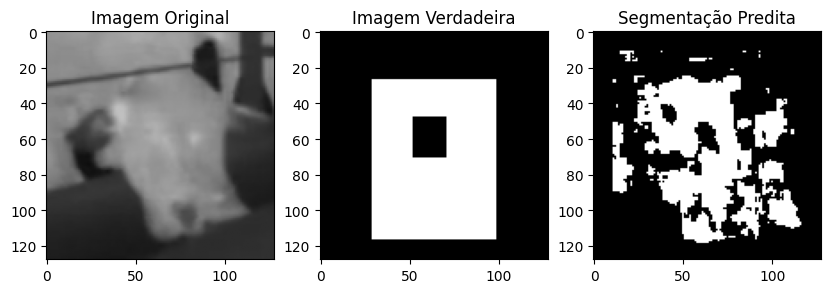

In [6]:

# Exibindo a comparação das segmentações de uma imagem entre dois modelos
def plot_prediction_comparison(model1, model2, X, Y, index):
    
    # Predição com o primeiro modelo
    pred1 = model1.predict(np.expand_dims(X[index], axis=0))
    pred1 = (pred1 > 0.5).astype(np.uint8)  # Binarizando a predição

    # Predição com o segundo modelo
    pred2 = model2.predict(np.expand_dims(X[index], axis=0))
    pred2 = (pred2 > 0.5).astype(np.uint8)  # Binarizando a predição

    plt.figure(figsize=(20, 5))

    # Imagem Original
    plt.subplot(1, 5, 1)
    plt.imshow(X[index])
    plt.title('Imagem Original')
    plt.axis('off')

    # Layer Verdadeira
    plt.subplot(1, 5, 2)
    plt.imshow(np.squeeze(Y[index]), cmap='gray')
    plt.title('Layer Verdadeira')
    plt.axis('off')

    # Predição Modelo 1
    plt.subplot(1, 5, 3)
    plt.imshow(np.squeeze(pred1), cmap='gray')
    plt.title('Predição Modelo 1')
    plt.axis('off')

    # Predição Modelo 2
    plt.subplot(1, 5, 4)
    plt.imshow(np.squeeze(pred2), cmap='gray')
    plt.title('Predição Modelo 2')
    plt.axis('off')


    plt.show()

# Exemplo de predição
plot_prediction_comparison(model, model2, X_val, Y_val, index=10)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Função para plotar os gráficos de acurácia e perda de dois modelos
def plot_accuracy_loss(history1, history2):

    # Gráfico de Acurácia
    plt.figure(figsize=(12, 6))
    plt.plot(history1.history['accuracy'], label='accuracy modelo 1', color='blue')
    plt.plot(history1.history['val_accuracy'], label='val_accuracy modelo 1', color='blue', linestyle='dashed')
    plt.plot(history2.history['accuracy'], label='accuracy modelo 2', color='red')
    plt.plot(history2.history['val_accuracy'], label='val_accuracy modelo 2', color='red', linestyle='dashed')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.title('Acurácia por Época - Comparação de Modelos')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfico de Perda
    plt.figure(figsize=(12, 6))
    plt.plot(history1.history['loss'], label='loss modelo 1', color='blue')
    plt.plot(history1.history['val_loss'], label='val_loss modelo 1', color='blue', linestyle='dashed')
    plt.plot(history2.history['loss'], label='loss modelo 2', color='red')
    plt.plot(history2.history['val_loss'], label='val_loss modelo 2', color='red', linestyle='dashed')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.title('Perda por Época - Comparação de Modelos')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy_loss(history, history2)



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Medir o tempo de treinamento
start_time = time.time()

training_time = time.time() - start_time
training_hours, training_minutes = divmod(training_time // 60, 60)
print(f"Tempo Total de Treinamento: {int(training_hours)} horas e {int(training_minutes)} minutos")

# Medir o tempo de inferência por imagem
start_time = time.time()
predictions = np.array([model.predict(np.expand_dims(img, axis=0)) for img in X_val])
inference_time = (time.time() - start_time) / len(X_val)
print(f"Tempo Médio de Inferência por Imagem: {inference_time:.4f} segundos")

# Calcular precisão, recall e F1-score
Y_val_binary = (Y_val > 0.5).astype(np.uint8)
predictions_binary = (predictions > 0.5).astype(np.uint8)

# Achando precisão, recall e F1-score para cada imagem
precision = precision_score(Y_val_binary.flatten(), predictions_binary.flatten(), average='binary')
recall = recall_score(Y_val_binary.flatten(), predictions_binary.flatten(), average='binary')
f1 = f1_score(Y_val_binary.flatten(), predictions_binary.flatten(), average='binary')

print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")